In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import heapq
import matplotlib.colors


In [51]:
import PIL
import datetime

# Algorithm
Custom adaptation of astar algorithm for 3D array with forced forward

In [25]:
def heuristic_function(a, b):
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

def astar_3D(space, origin_xy, destination_xy):
    # make origin 3D with timeslice 0
    origin = origin_xy[0], origin_xy[1], 0
    # logs the path
    came_from = {}
    # holds the legal next moves in order of priority
    frontier = []
    # define legal moves:
    # up, down, left, right, stay in place.
    # no diagonals and always move forward one time step (z) 
    neighbours = [(0,0,1),(0,1,1),(0,-1,1),(1,0,1),(-1,0,1)]

    cost_so_far = {origin: 0}
    priority = {origin: heuristic_function(origin_xy, destination_xy)}
    heapq.heappush(frontier, (priority[origin], origin))

    # While there is still options to explore
    while frontier:
        
        current = heapq.heappop(frontier)[1]

        # if current position is destination,
        # break the loop and find the path that lead here
        if (current[0], current[1]) == destination_xy:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        for i, j, k in neighbours:
            move = current[0] + i, current[1] + j, current[2] + k
            
            # check that move is legal
            if ((0 <= move[0] < space.shape[0]) &
                (0 <= move[1] < space.shape[1]) &
                (0 <= move[2] < space.shape[2])):
                
                if space[move[0], move[1], move[2]] != 1:

                    new_cost = 1
                    new_total = cost_so_far[current] + new_cost

                    if move not in cost_so_far:
                        cost_so_far[move] = new_total
                        # calculate total cost
                        priority[move] = new_total + heuristic_function(move, destination_xy)
                        # update frontier
                        heapq.heappush(frontier, (priority[move], move))
                        # log this move
                        came_from[move] = current
                    
    return 'no solution found :('


In [26]:
def convert_forecast(data_cube):
    # take mean of forecasts
    arr_world = np.min(data_cube, axis=2)
    # binarize to storm (1) or safe (0)
    arr_world = arr_world >= 15
    # from boolean to binary
    arr_world = arr_world.astype(int)
    # swap axes so x=0, y=1, z=2, day=3
    arr_world = np.swapaxes(arr_world,0,2)
    arr_world = np.swapaxes(arr_world,1,3)
    arr_world = np.swapaxes(arr_world,2,3)

    return(arr_world)

In [133]:
def plot_timeslice(timeslice, cities, solution):
    plt.figure(figsize=(5,5))
    # black for storm
    plt.imshow(timeslice[:,:].T, aspect='equal', cmap=plt.get_cmap('binary'))
    
    for c,x,y in zip(cities.cid, cities.xid, cities.yid):
        if c == 0:
            plt.scatter([x-1], [y-1], c='red')
        else:
            plt.scatter([x-1], [y-1], c='blue')
            
    #x, y, z = zip(*solution)
    x = solution.x
    y = solution.y
    z = solution.z
    plt.plot(list(x), list(y), linestyle='-', color='r')

    plt.show()


In [130]:
def plot_series(world, cities, solution):
    timesteps = list(range(0, 540, 30))

    for t in timesteps:
        print(t)
        timeslice = world[:,:,t]
        solution_subset = [i for i in solution if t <= i[2] <= t + 30]
        if len(solution_subset) > 0:
            plot_timeslice(timeslice, cities, solution_subset)

In [232]:
def plot_solution(world, cities, solution, day):
    timesteps = list(range(0, 540, 30))
    solution = solution.loc[solution.day == day,:]
    # colour map for cities
    cmap = plt.cm.cool
    norm = matplotlib.colors.Normalize(vmin=1, vmax=10)
    # colour map for weather
    cm = matplotlib.colors.LinearSegmentedColormap.from_list('grid', [(1, 1, 1), (0.5, 0.5, 0.5)], N=2)

    for t in timesteps:
        timeslice = world[:,:,t]
        moves_sofar = solution.loc[solution.z <= t,:]
        moves_new = solution.loc[(t <= solution.z) & (solution.z <= t + 30),:]
        
        if len(solution_subset) > 0:    
            plt.figure(figsize=(5,5))
            plt.imshow(timeslice[:,:].T, aspect='equal', cmap = cm)

            # plot old moves
            for city in moves_sofar.city.unique():
                moves_sofar_city = moves_sofar.loc[moves_sofar.city == city,:]
                x = moves_sofar_city.x
                y = moves_sofar_city.y
                z = moves_sofar_city.z
                plt.plot(list(x), list(y), linestyle='-', color='black')
                
            # plot new moves
            for city in moves_new.city.unique():
                moves_new_city = moves_new.loc[moves_new.city == city,:]
                x = moves_new_city.x
                y = moves_new_city.y
                z = moves_new_city.z
                plt.plot(list(x), list(y), linestyle='-', color=cmap(norm(city))) 
                
            # plot cities
            for city,x,y in zip(cities.cid, cities.xid, cities.yid):
                if city == 0:
                    plt.scatter([x-1], [y-1], c='black')
                else:
                    # balloon still en-route?
                    if city in moves_new.city.unique():
                        plt.scatter([x-1], [y-1], c=cmap(norm(city)))
                    else:
                        plt.scatter([x-1], [y-1], c='black')
            
            # save and display
            plt.savefig('img_day' + str(day) + '_timestep_' + str(t) + '.png')
            plt.show()

In [29]:
# Toy data
world = np.ones((10,10,100))
world = world >= 15
world = world.astype(int)

origin = (0,0,0)
destinations = [(9,9, timeslice) for timeslice in range(0,100)]

print(world.shape)

(10, 10, 100)


# Data
Generate map of the world as binary 3D numpy array to find path in

In [30]:
# read h5 format back to numpy array
# h5f = h5py.File('../data/METdata.h5', 'r')
# train = h5f['train'][:]
# test = h5f['test'][:]
# h5f.close()

In [31]:
%pwd

u'/Users/laurens.geffert/local/personal/future_challenge_hackathon/code'

In [32]:
data_cube = np.load('../data/5D_test.npy')

In [33]:
# convert forecast to world array
arr_world = convert_forecast(data_cube)
print(data_cube.shape)
print(arr_world.shape)

(5, 18, 10, 548, 421)
(548, 421, 18, 5)


In [34]:
# repeat time slices x30
arr_world_big = np.repeat(arr_world, repeats=30, axis=2)
print(arr_world_big.shape)

(548, 421, 540, 5)


# Run

In [47]:
#x = astar_3D(space=arr_world_big[:,:,:,0], 
#             origin_xy=origin, 
#             destination_xy=destination)


In [48]:
solution = pd.DataFrame([], columns=['x','y','z','day','city'])
origin = cities.loc[cities.cid == 0, ['xid', 'yid']]
origin = (origin.iloc[0,0], origin.iloc[0,1])

# iterate over days
for i in range(arr_world.shape[3]):

    # get data for specific day
    arr_day = arr_world_big[:,:,:,i]

    # iterate over destinations
    for j in range(cities.shape[0] - 1):
        print('calculating day: '+str(i+1)+', city: '+str(j+1))

        # find coordinates of target city
        destination = cities.loc[cities.cid == j+1, ['xid', 'yid']]
        destination = (destination.iloc[0,0], destination.iloc[0,1])

        x = astar_3D(space=arr_day, 
                     origin_xy=origin, 
                     destination_xy=destination)
        
        # check if solution was found
        if type(x) == str:
            out = pd.DataFrame(
                np.array([[i]*540,[j]*540,[origin[0]]*540,[origin[1]]*540,range(540)]).T, 
                columns=['day','city','x','y','z'])
        
        else:
            out = (pd.DataFrame(zip(*x))
                     .transpose()
                     .rename(index=str, columns={0:'x', 1:'y', 2:'z'})
                     .append(pd.DataFrame({'x':origin[0],'y':origin[1],'z':[0]}))
                     .sort_values(by=['z'])
                     .assign(day=i+1, 
                             city=j+1))

        solution = solution.append(out, ignore_index=True)


calculating day: 1, city: 1
calculating day: 1, city: 2
calculating day: 1, city: 3
calculating day: 1, city: 4
calculating day: 1, city: 5
calculating day: 1, city: 6
calculating day: 1, city: 7
calculating day: 1, city: 8
calculating day: 1, city: 9
calculating day: 1, city: 10
calculating day: 2, city: 1
calculating day: 2, city: 2
calculating day: 2, city: 3
calculating day: 2, city: 4
calculating day: 2, city: 5
calculating day: 2, city: 6
calculating day: 2, city: 7
calculating day: 2, city: 8
calculating day: 2, city: 9
calculating day: 2, city: 10
calculating day: 3, city: 1
calculating day: 3, city: 2
calculating day: 3, city: 3
calculating day: 3, city: 4
calculating day: 3, city: 5
calculating day: 3, city: 6
calculating day: 3, city: 7
calculating day: 3, city: 8
calculating day: 3, city: 9
calculating day: 3, city: 10
calculating day: 4, city: 1
calculating day: 4, city: 2
calculating day: 4, city: 3
calculating day: 4, city: 4
calculating day: 4, city: 5
calculating day: 

In [49]:
solution.to_csv('solution.csv')

In [144]:
solution = pd.read_csv('solution.csv', index_col=0)

In [145]:
# convert time slices to timestamps
solution['time'] = solution['z'].apply(lambda x: ':'.join(str(datetime.timedelta(seconds=x * 2 + 180)).split(':')[1:]))

In [147]:
# re-adjust day number
solution['day'] = solution.day + 5

In [148]:
solution.head()

,city,day,x,y,z,time
0,1,11,142,328,0,03:00
1,1,11,142,327,1,03:02
2,1,11,142,326,2,03:04
3,1,11,142,325,3,03:06
4,1,11,142,324,4,03:08


In [149]:
out = solution[['city','day','time','x','y']]
out.head()

,city,day,time,x,y
0,1,11,03:00,142,328
1,1,11,03:02,142,327
2,1,11,03:04,142,326
3,1,11,03:06,142,325
4,1,11,03:08,142,324


In [57]:
out.to_csv('out.csv', index=False, header=False)

In [154]:
x2 = solution.loc[solution.day == 11,['x','y','z','city']]
x2.head()

,x,y,z,city
0,142,328,0,1
1,142,327,1,1
2,142,326,2,1
3,142,325,3,1
4,142,324,4,1


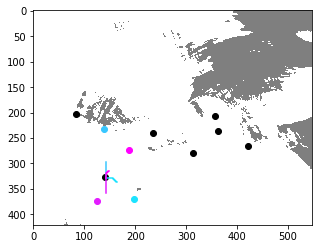

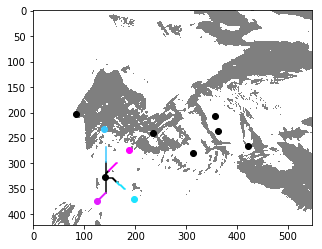

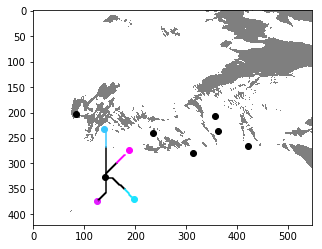

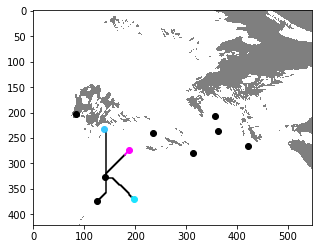

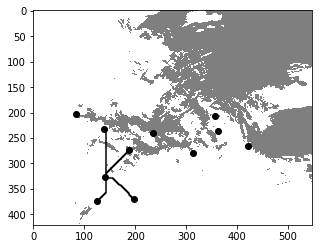

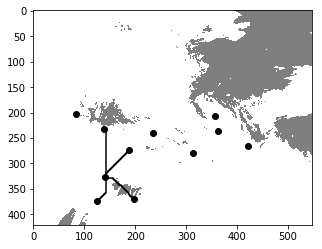

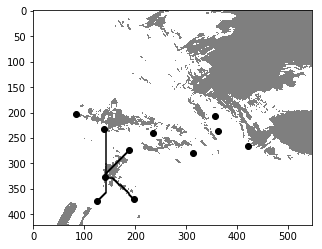

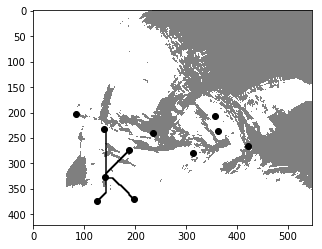

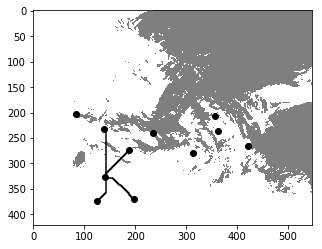

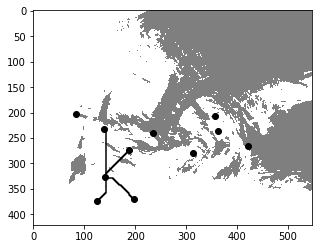

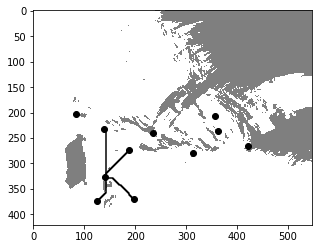

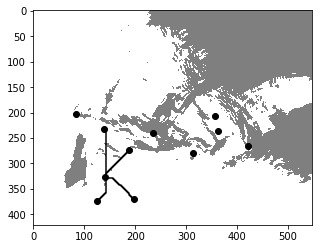

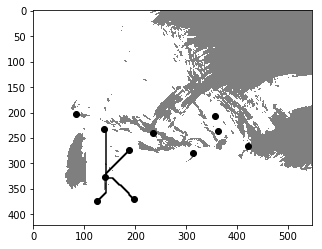

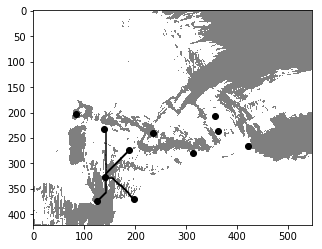

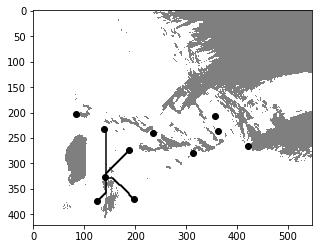

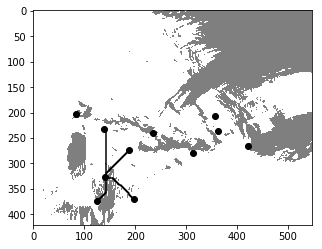

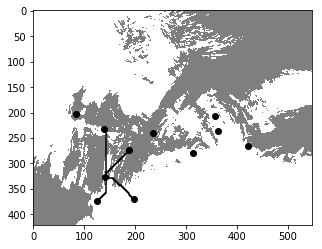

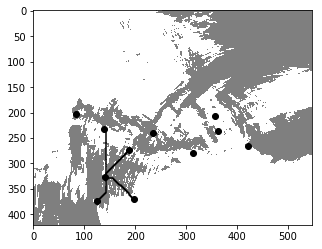

In [237]:
plot_solution(arr_world_big[:,:,:,0], cities, solution, 15)